# REKOMENDASI MATERI BERDASARKAN BANYAKNYA KESALAHAN USER SAAT MENJAWAB SOAL

### IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt

### LOAD DATASET

In [2]:
data = pd.read_csv('../latihan4/data/Python_Programming_Questions_Dataset_bersih.csv')  

In [3]:
# Tukar Input dan Output
data['Corrected_Input'] = data['Output']
data['Corrected_Output'] = data['Input']
data['text'] = data['Instruction'] + " " + data['Corrected_Input'] + " " + data['Corrected_Output']

In [4]:
# Menambah kolom materi
def categorize_question(Instruction):
    if re.search(r'\b(print|hello world|basic)\b', Instruction, re.IGNORECASE):
        return 'Introduction Python'
    elif re.search(r'\b(\+|\-|\*|\/|\%|\*\*|==|!=|<|>|<=|>=|=)\b', Instruction):
        return 'Operator'
    elif re.search(r'\b(int|float|string|bool|type)\b', Instruction, re.IGNORECASE):
        return 'Data Type'
    elif re.search(r'\b(list|tuple|dict|set|array)\b', Instruction, re.IGNORECASE):
        return 'Data Structure'
    elif re.search(r'\b(if|else|while|for|break|continue)\b', Instruction, re.IGNORECASE):
        return 'Control Structure'
    elif re.search(r'\b(def|function|return)\b', Instruction, re.IGNORECASE):
        return 'Function'
    elif re.search(r'\b(class|object|inheritance|method|self)\b', Instruction, re.IGNORECASE):
        return 'OOP'
    else:
        return 'Lainnya'

In [26]:
# Menerapkan pada dataset
data['materi'] = data['Instruction'].apply(categorize_question)

# Menambahkan kolom ID soal
data['question_id'] = data.index 
data.head()

,Instruction,Input,Output,Corrected_Input,Corrected_Output,text,materi,question_id,target
0,Create a function in Python which takes a list...,"[3, 4, 5]",def sum_squares(nums):\r\n result = 0\r\n ...,def sum_squares(nums):\r\n result = 0\r\n ...,"[3, 4, 5]",Create a function in Python which takes a list...,Data Structure,0,1
1,Design a function in Python that sorts a list ...,"['red', 'green', 'orange']",def sort_list_alphabetically(input_list): \r\n...,def sort_list_alphabetically(input_list): \r\n...,"['red', 'green', 'orange']",Design a function in Python that sorts a list ...,Data Structure,1,1
2,Edit the following Python code such that it wi...,"days = [""Monday"", ""Thuesday"", ""Wednesday"", ""Th...","days = [""Monday"", ""Tuesday"", ""Wednesday"", ""Thu...","days = [""Monday"", ""Tuesday"", ""Wednesday"", ""Thu...","days = [""Monday"", ""Thuesday"", ""Wednesday"", ""Th...",Edit the following Python code such that it wi...,Introduction Python,2,4
3,Create a Python program to check if an integer...,Integer : 10,def is_divisible_by_5(number):\r\n if (numb...,def is_divisible_by_5(number):\r\n if (numb...,Integer : 10,Create a Python program to check if an integer...,Control Structure,3,0
4,Create a Python algorithm to calculate the tar...,"subtrahend: 10\r\nlist: [4, 3, 8, 6, 5]","def target_sum(subtrahend, lst):\r\n target...","def target_sum(subtrahend, lst):\r\n target...","subtrahend: 10\r\nlist: [4, 3, 8, 6, 5]",Create a Python algorithm to calculate the tar...,Data Structure,4,1


In [27]:
df = pd.DataFrame(data)
print(df.duplicated())
# Melihat total missing value
total_missing = df.isnull().sum().sum()
print(f'Total missing value: {total_missing}')


0       False
1       False
2       False
3       False
4       False
        ...  
7555    False
7556    False
7557    False
7558    False
7559    False
Length: 7560, dtype: bool
Total missing value: 0


In [28]:
# Dataset dummy interaksi user
interaction_data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3],
    'question_id': [0, 1, 1, 2, 2, 3, 4],
    'attempts': [3, 2, 4, 1, 3, 2, 1],
    'correct': [1, 0, 1, 1, 1, 0, 1],
    'duration': [30, 45, 60, 35, 50, 20, 25]
}
interaction_df = pd.DataFrame(interaction_data)

# Menggabungkan interaksi dengan soal
interaction_df = interaction_df.merge(data[['question_id', 'materi']], on='question_id', how='left')

### PREPROCESSING DATA

In [29]:
# Fitur interaksi user
error_data = interaction_df.groupby('question_id').agg({
    'attempts': 'mean',
    'correct': 'mean',
    'duration': 'mean'
}).reset_index()

# Hitung kesalahan per materi
error_data['avg_error_rate'] = 1 - error_data['correct']
print(error_data)

# Representasi TF-IDF untuk teks
tfidf = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf.fit_transform(data['text']).toarray()

# Mendapatkan materi dengan kesalahan tertinggi
top_error_materis = error_data.sort_values(by='avg_error_rate', ascending=False).head(5)

# Menggabungkan fitur TF-IDF dengan kolom materi
features = pd.DataFrame(tfidf_matrix)

# Menambahkan kolom 'materi' ke dalam fitur
features['materi'] = data['materi']

# Encode target materi
data['target'] = data['materi'].astype('category').cat.codes
num_classes = len(data['target'].unique())

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features.drop('materi', axis=1), data['target'], test_size=0.2, random_state=42)

# One-hot encoding untuk target
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

   question_id  attempts  correct  duration  avg_error_rate
0            0       3.0      1.0      30.0             0.0
1            1       3.0      0.5      52.5             0.5
2            2       2.0      1.0      42.5             0.0
3            3       2.0      0.0      20.0             1.0
4            4       1.0      1.0      25.0             0.0



### MEMBANGUN MODEL


In [50]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.7))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
    model.add(BatchNormalization())
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-4, 1e-6])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [51]:
# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='CodeyApp_recommendation_system'
)


# pencarian hyperparameter
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Mendapatkan hyperparameter yang bagus
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Reloading Tuner from model_tuning\CodeyApp_recommendation_system\tuner0.json


### TRAIN MODEL

In [52]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# Training model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/50
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1684 - loss: 5.4383
Epoch 1: val_loss improved from inf to 3.84906, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1689 - loss: 5.4313 - val_accuracy: 0.3003 - val_loss: 3.8491 - learning_rate: 0.0010
Epoch 2/50
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3755 - loss: 3.7933
Epoch 2: val_loss improved from 3.84906 to 3.21919, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3761 - loss: 3.7901 - val_accuracy: 0.5384 - val_loss: 3.2192 - learning_rate: 0.0010
Epoch 3/50
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5063 - loss: 3.0664
Epoch 3: val_loss improved from 3.21919 to 2.57591, saving model to best_model.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5065 - loss: 3.0650 - val_accuracy: 0.6323 - val_loss: 2.5759 - learning_rate: 0.0010
Epoch 4/50
187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accura

In [ ]:
# Load best model yang tersimpan
model = tf.keras.models.load_model('best_model.h5')

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7462 - loss: 1.1001
Test Loss: 1.1303646564483643
Test Accuracy: 0.7361111044883728


### PLOTTING

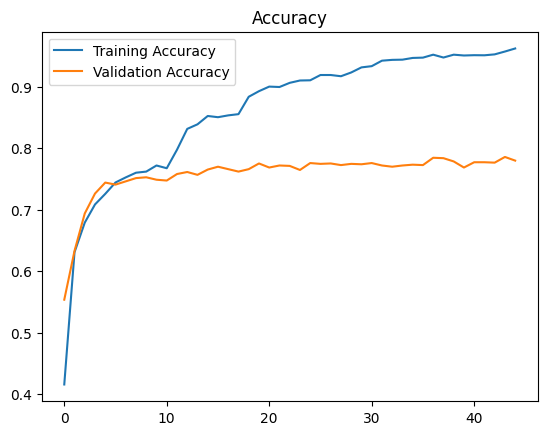

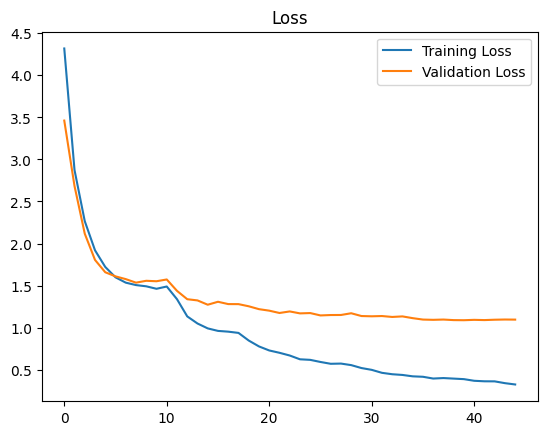

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


### MEMBANGUN REKOMENDASI

In [14]:
# Menghitung rata-rata kesalahan per materi
avg_error_per_materi = error_data.groupby(data['materi'])['avg_error_rate'].mean().reset_index()

# Mengurutkan materi berdasarkan tingkat kesalahan tertinggi
recommended_materials = avg_error_per_materi.sort_values(by='avg_error_rate', ascending=False)

# Tampilkan 5 materi dengan tingkat kesalahan tertinggi
print("Materi yang perlu dipelajari lebih lanjut (berdasarkan kesalahan siswa):")
print(recommended_materials.head())

Materi yang perlu dipelajari lebih lanjut (berdasarkan kesalahan siswa):
                materi  avg_error_rate
0    Control Structure        1.000000
1       Data Structure        0.166667
2  Introduction Python        0.000000


In [15]:
# Misalnya, prediksi materi untuk user berdasarkan interaksi mereka
# Data interaksi yang relevan
user_interaction = {
    'user_id': [4, 4, 4, 4, 4, 4],
    'question_id': [0, 2, 3, 5, 110, 130],
    'attempts': [3, 4, 2, 1, 1, 4],
    'correct': [0, 0, 1, 0, 0, 1],
    'duration': [60, 30, 35, 20, 25, 15]
}

user_interaction_df = pd.DataFrame(user_interaction)
user_interaction_df = user_interaction_df.merge(data[['question_id', 'materi']], on='question_id', how='left')

# Hitung rata-rata kesalahan per materi
user_error_data = user_interaction_df.groupby('materi').agg({
    'attempts': 'mean',
    'correct': 'mean',
    'duration': 'mean'
}).reset_index()

user_error_data['avg_error_rate'] = 1 - user_error_data['correct']

# Rekomendasikan materi dengan kesalahan tertinggi
user_recommended_materials = user_error_data.sort_values(by='avg_error_rate', ascending=False).head(1)
print("Materi yang perlu dipelajari oleh siswa:")
print(user_recommended_materials)


Materi yang perlu dipelajari oleh siswa:
    materi  attempts  correct  duration  avg_error_rate
2  Lainnya       1.0      0.0      25.0             1.0


In [16]:
model.save('best_model.keras')

## Convert ke TFLITE

In [17]:
model = tf.keras.models.load_model('best_model.keras')


In [18]:
# Inisialisasi converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp_tpovord\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp_tpovord\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmp_tpovord'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2000), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2205501196048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501196432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501197776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501197008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501197968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501194704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501198736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501199888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501200464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501198352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205501200656:

## Test Model dengan TFLite Interpreter

In [19]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [20]:
input_details = interpreter.get_input_details()
input_shape = input_details[0]["shape"]
input_dtype = input_details[0]["dtype"]

In [21]:
input_data = np.random.random_sample(input_shape).astype(input_dtype)


In [22]:
interpreter.set_tensor(input_index, input_data)

In [23]:
# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_index)
print("Output Data:", output_data)

Output Data: [[0. 0. 0. 0. 0. 0. 0. 1.]]
